In [28]:
import matplotlib

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (30,30)
from IPython.display import Image
from pydotplus import graph_from_dot_data

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('df.csv')

In [3]:
df

Unnamed: 0  matchID      date day_of_week name league  game_number  \
0                0        0  19460416         Tue  DET     AL            1   
1               10       10  19460417         Wed  PHA     AL            2   
2               16       16  19460418         Thu  DET     AL            3   
3               19       19  19460418         Thu  BRO     NL            3   
4               23       23  19460420         Sat  BOS     AL            4   
...            ...      ...       ...         ...  ...    ...          ...   
167739       83866    94926  20161002         Sun  CIN     NL          162   
167740       83867    94927  20161002         Sun  COL     NL          162   
167741       83868    94928  20161002         Sun  PHI     NL          162   
167742       83870    94930  20161002         Sun  SLN     NL          162   
167743       83871    94931  20161002         Sun  WAS     NL          162   

        score  length_outs day_night park_id  attendance  length_minutes  \
0           2           51         D   DET04     52900.0           110.0   
1           7           51         D   PHI11     11901.0           120.0   
2           6           51         D   DET04     16469.0           118.0   
3           8           51         D   NYC15     31825.0           136.0   
4           2           51         D   BOS07     30446.0            94.0   
...       ...          ...       ...     ...         ...             ...   
167739      4           54         D   CIN09     32587.0           198.0   
167740      4           60         D   DEN02     27762.0           203.0   
167741      5           51         D   PHI13     36935.0           159.0   
167742     10           51         D   STL10     44615.0           192.0   
167743     10           51         D   WAS11     28730.0           216.0   

        line_score  at_bats  hits  doubles  triples  homeruns   rbi  \
0        01010000x     28.0   6.0      1.0      0.0       1.0   2.0   
1        10000051x     31.0   9.0      2.0      1.0       0.0   6.0   
2        10030011x     36.0  12.0      3.0      1.0       0.0   6.0   
3        00512000x     32.0   9.0      1.0      2.0       0.0   6.0   
4        10000001x     24.0   2.0      0.0      0.0       1.0   2.0   
...            ...      ...   ...      ...      ...       ...   ...   
167739   300100000     32.0   6.0      2.0      0.0       0.0   4.0   
167740  1100100010     41.0  13.0      4.0      0.0       1.0   4.0   
167741   00100031x     33.0  10.0      1.0      0.0       0.0   3.0   
167742   00100360x     36.0  12.0      2.0      0.0       1.0  10.0   
167743   03023002x     30.0  10.0      2.0      0.0       1.0  10.0   

        sacrifice_hits  sacrifice_flies  hit_by_pitch  walks  \
0                  0.0              0.0           0.0    5.0   
1                  3.0              0.0           0.0    2.0   
2                  0.0              0.0           0.0    6.0   
3                  0.0              0.0           0.0    4.0   
4                  1.0              0.0           0.0    6.0   
...                ...              ...           ...    ...   
167739             0.0              0.0           1.0    3.0   
167740             1.0              0.0           1.0    3.0   
167741             0.0              1.0           0.0    2.0   
167742             0.0              2.0           0.0    4.0   
167743             1.0              1.0           1.0    8.0   

        intentional walks  ...  errors  passed_balls  double_plays  \
0                     1.0  ...     0.0           0.0           1.0   
1                     0.0  ...     0.0           0.0           2.0   
2                     1.0  ...     0.0           0.0           0.0   
3                     0.0  ...     1.0           0.0           1.0   
4                     0.0  ...     0.0           0.0           1.0   
...                   ...  ...     ...           ...           ...   
167739                0.0  ...     0.0        

In [4]:
for column in df.columns:
    if '_id' in column:
        df.drop(columns=column, inplace=True)

# Feature selection

Look at the vif and run a decision tree to find the feature importance to help select those.

In [5]:
y = df['winner']
X = df.drop(columns=['Unnamed: 0', 'winner', 'league', 'winning_team', 'line_score'])

## Correlation matrix

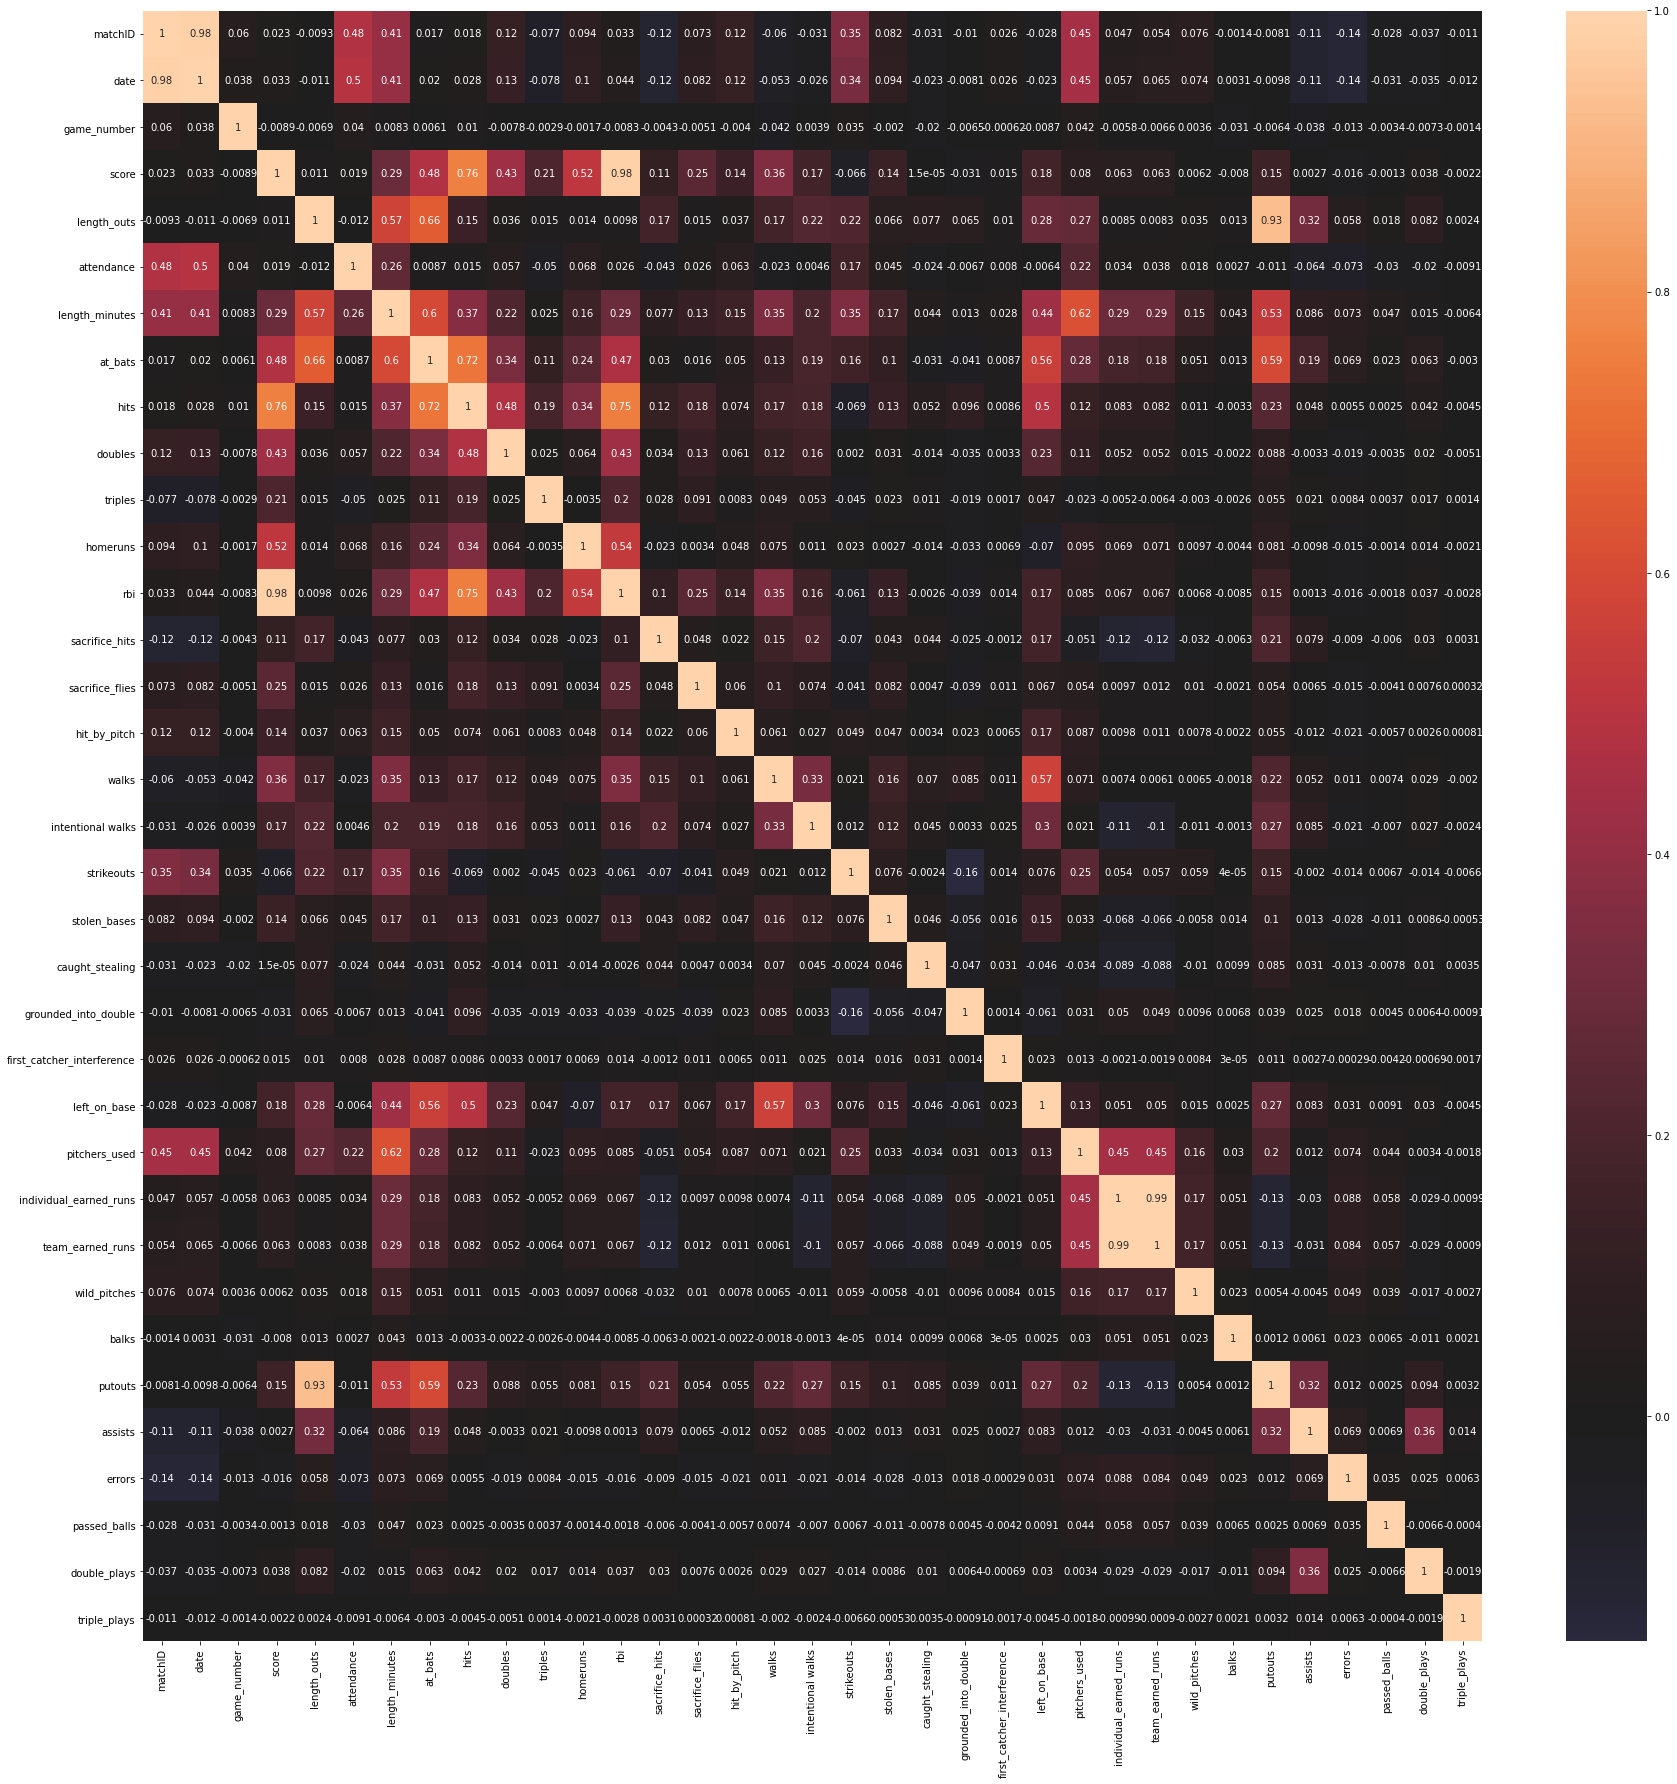

In [6]:
sns.heatmap(X.corr(), center=0, annot=True);

## Variance Inflation Factor

In [7]:
teams = X['name'].str.get_dummies()
day = X['day_of_week'].str.get_dummies()
dn = X['day_night'].str.get_dummies()
X = X.join(teams)
X = X.join(day)
X = X.join(dn)
X.drop(columns=['name','day_of_week', 'day_night'], inplace=True)

# Columns dropped after VIF analysis:
X.drop(columns=['matchID', 'score', 'length_outs', 'at_bats', 'putouts'], inplace=True)

In [8]:
Xvif = X.loc[:, :'triple_plays']

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(Xvif.values, i) for i in range(Xvif.shape[1])]
list(zip(Xvif.columns, vif))

[('date', 52.25767816012181),
 ('game_number', 3.9394937437569624),
 ('attendance', 5.210154537161773),
 ('length_minutes', 93.12534866001145),
 ('hits', 101.69107571630285),
 ('doubles', 3.4815180330497326),
 ('triples', 1.312396962232327),
 ('homeruns', 2.9664037914251904),
 ('rbi', 33.882293209300656),
 ('sacrifice_hits', 1.481033665829483),
 ('sacrifice_flies', 1.377926827136632),
 ('hit_by_pitch', 1.640210564980714),
 ('walks', 19.523175301288383),
 ('intentional walks', 1.508302877095632),
 ('strikeouts', 6.825436230282698),
 ('stolen_bases', 1.513482304493216),
 ('caught_stealing', 1.622858101054267),
 ('grounded_into_double', 3.1803784259621626),
 ('first_catcher_interference', 1.0098156072062867),
 ('left_on_base', 65.93028895516177),
 ('pitchers_used', 11.378128537076593),
 ('individual_earned_runs', 261.8516934329826),
 ('team_earned_runs', 258.97142362574857),
 ('wild_pitches', 1.32534963903639),
 ('balks', 1.0447398298345965),
 ('assists', 12.78420279145401),
 ('errors', 1

## Decision Tree to identify important features

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42
                                                   )
# Initialising K-Folds
kfold = KFold(n_splits=5,
              random_state=42,
              shuffle=True
             )

In [ ]:
# OneHotEncode step
# ohe = OneHotEncoder()
# ohe.fit(X_train)
# X_train_ohe = ohe.transform(X_train).toarray()

In [12]:
# Train Decision tree
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

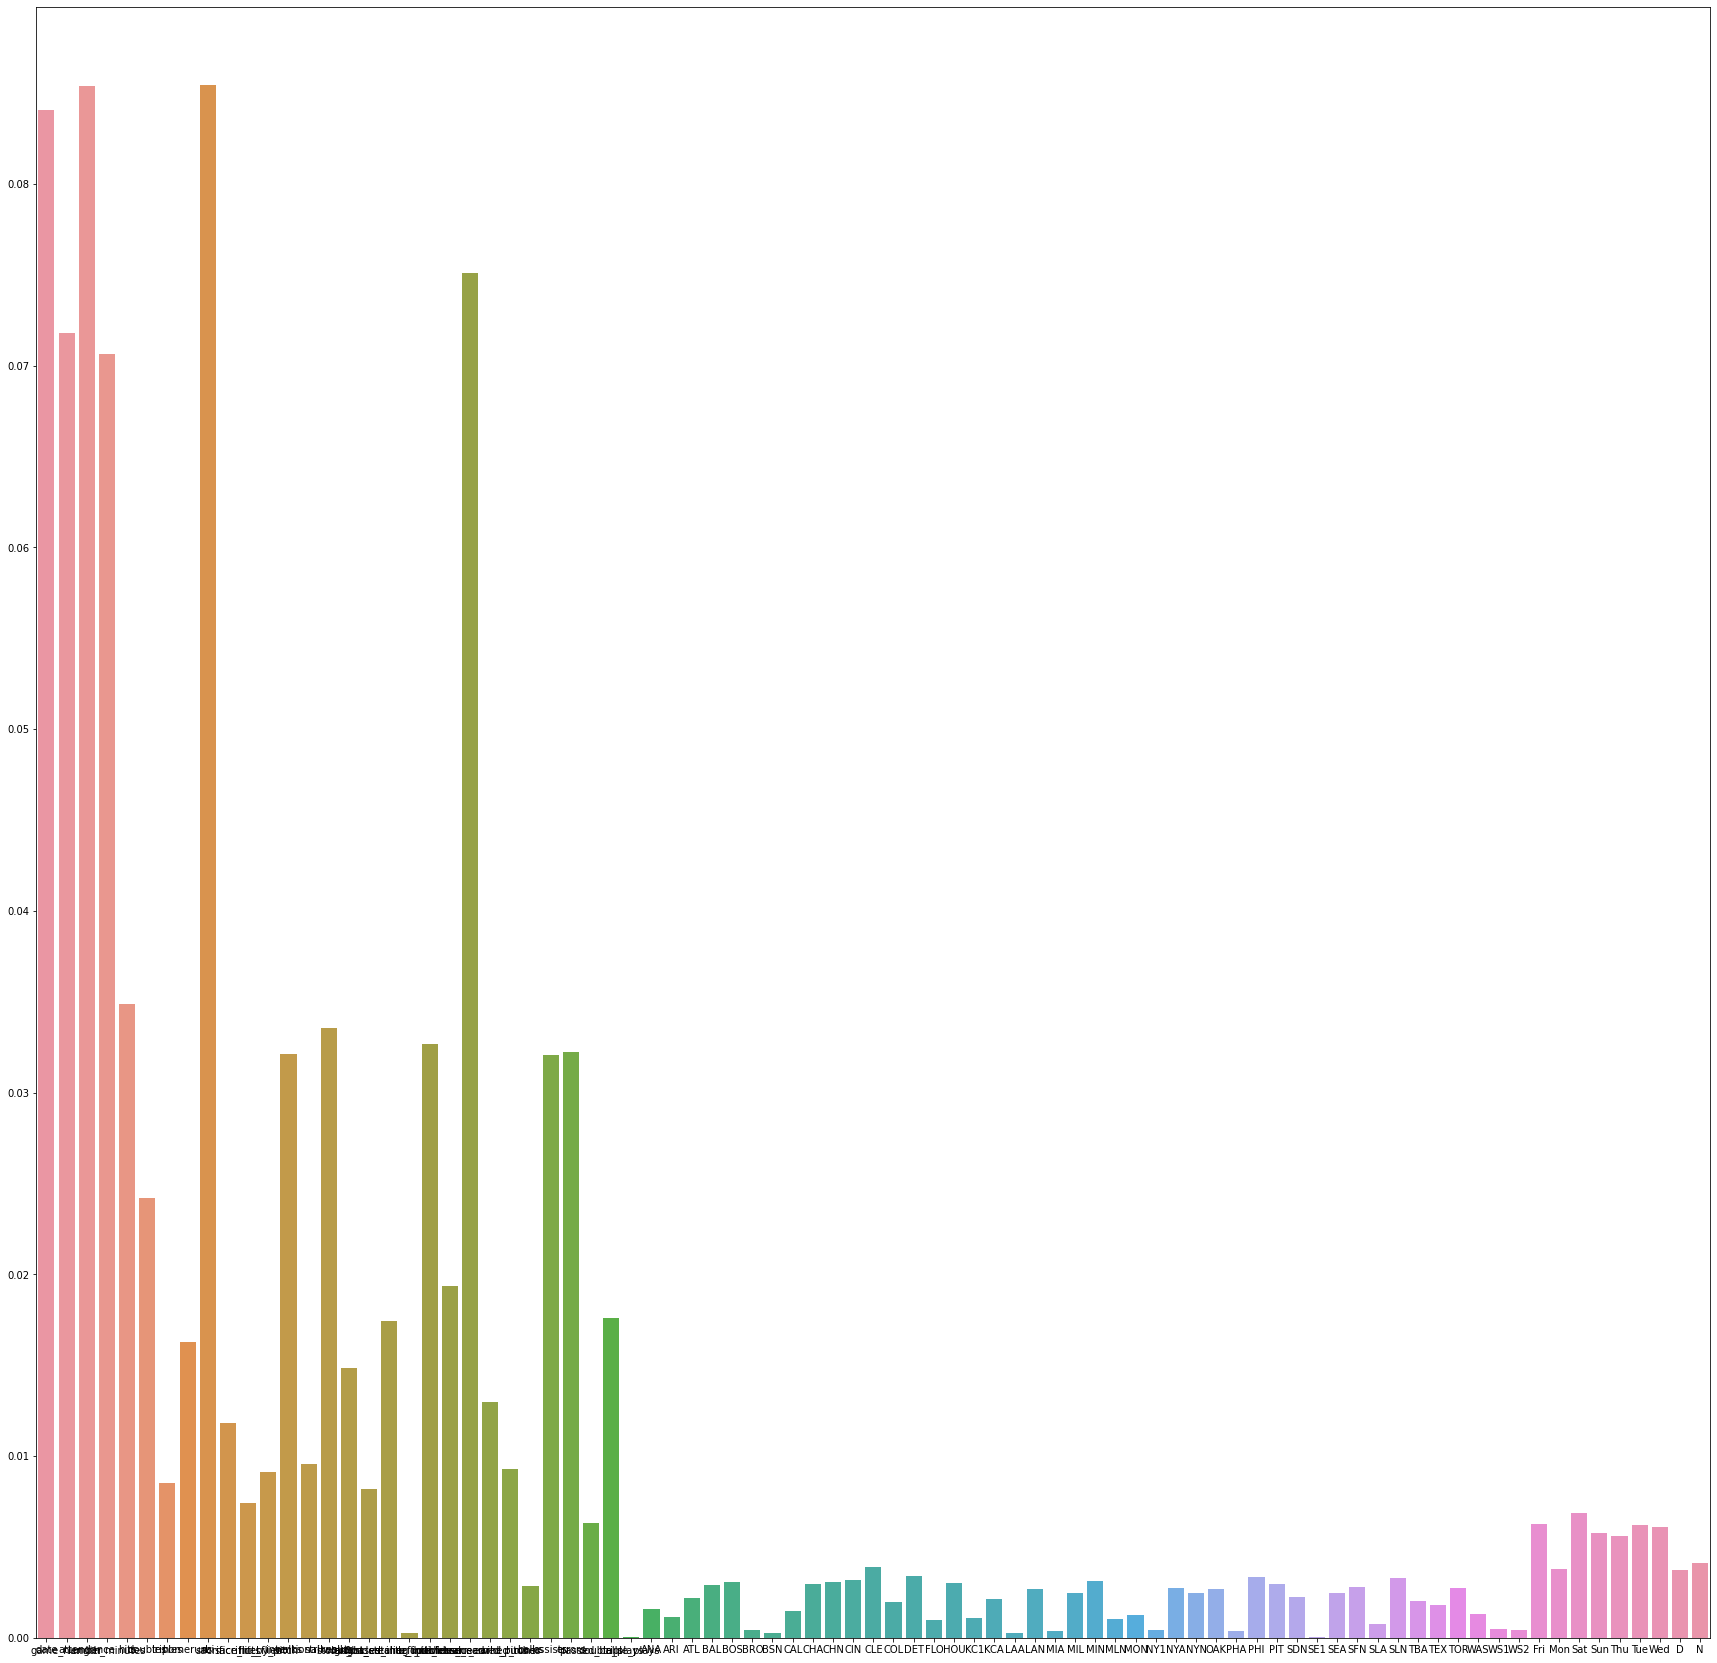

In [48]:
zip(X_train.columns,clf.feature_importances_)

sns.barplot(x=features[0],
            y=features[1],
           );

### The following cell takes forever to run

In [ ]:
# Graphical representation of the decision tree
# ohe_df = pd.DataFrame(X_train,
#                       columns=X_train.columns
#                      )
# dot_data = export_graphviz(clf, #sdjasdkl
#                            out_file=None, 
#                            feature_names=ohe_df.columns,  
#                            class_names=np.unique(y).astype('str'), 
#                            filled=True,
#                            rounded=True,
#                            special_characters=True
#                           )
# graph = graph_from_dot_data(dot_data)  
# Image(graph.create_png())

# Baseline model: logistic regression

## Scaling the data

In [29]:
# Getting dummies /!\ change df[relevant_columns] with the columns that need to get dumbed down
# X = pd.get_dummies(df[relevant_columns], drop_first=True)
# X = X.fillna(value=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Accuracy of the logistic model

In [31]:
y_hat_train = logreg.predict(X_train)
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts(normalize=True))

0.0    0.500628
1.0    0.499372
Name: winner, dtype: float64
